<font size = "5"><b>ПРОЕКТНАЯ РАБОТА</b></font>

<font size = '4'><b>A/B-тестирование: recommender_system_test</b></font></br>
<font size = '3'> период наблюдения: <b>07.12.2020 - 04.01.2021</b></font>

<a name = "0.0"></a><font size = "4"><b>Содержание</b></font><br/>
* [0. Описание проекта](#0.)
* [1. Ознакомление и предобработка первичных данных](#1.)
    * [1.1 Обзор общей информации и корректировка данных](#1.1.)
    * [1.2 Оценка корректности проведения теста](#1.2.)
* [2. Проведение исследовательского анализа данных](#2.)
    * [2.1 Распределение количества событий на пользователя](#2.1.)
    * [2.2 Распределение событий по дням](#2.2.)
    * [2.3 Как меняется конверсия в воронке на разных этапах](#2.3.)
* [3. Оценка результатов A/B-тестирования](#3.)
    * [3.1 Анализ результатов A/B-тестирования](#3.1.)
    * [3.2 Проверка статистической разницы долей z-критерием](#3.2.)
* [4. Вывод](#4.)

<a name = '0.'></a><font size = '4'><b>Описание проекта</b></font><br>
<font size = '2'>[Содержание](#0.0)</font>

<font size = "3"><b>Задача:</b></font><br>
Провести оценку результатов <b>A/B-теста</b>.

В распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

<b>Необходимо:</b>
* Оценить корректность проведения теста, необходимо проверить:
    - пересечение тестовой аудитории с конкурирующим тестом,
    - совпадение теста и маркетинговых событий, другие проблемы временных границ теста.
* Проанализировать результаты теста


<b>Техническое задание:</b>
- Название теста: `recommender_system_test`;
- группы:
    * А — контрольная,
    * B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

<font size = '3'><b>Описание данных:</b></font>

________________
<b>ab_project_marketing_events.csv</b> — календарь маркетинговых событий на 2020 год.

<b>Структура файла:</b>

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

________________
<b>final_ab_new_users.csv</b> — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

<b>Структура файла:</b>

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

________________
<b>final_ab_events.csv</b> — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

<b>Структура файла:</b>

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

________________
<b>final_ab_participants.csv</b> — таблица участников тестов.

<b>Структура файла:</b>

- `user_id` — идентификатор пользователя;
- `group` — группа пользователя;
- `ab_test` — название теста.

________________
<font size = '3'><b>Этапы выполнения проекта:</b></font>
* Обзор общей информации и корректировка данных
* Оценка корректности проведения теста
* Проведение исследовательского анализа данных
* Оценка результатов A/B-тестирования
* Вывод

<a name = '1.'></a><font size = '4'><b>1. Ознакомление, предобработка первичных данных и оценка корректности проведения теста</b></font><br>
<font size = '2'>[Содержание](#0.0)</font>

<a name = "1.1."></a><font size = "3"><b>1.1 Обзор общей информации и корректировка данных</b></font><br/>
<font size = "2">[содержание](#0.0)</font>

In [864]:
# Библиотеки
# Обработки и анализа данных 
import pandas as pd

# Визуализации данных
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import plotly.express as px
from plotly import graph_objects as go

#Общие математические, числовые операции в виде функций и пакет статистических функций 
import numpy as np
import math as mt
import random
from scipy import stats
from scipy.stats import rankdata
from scipy.stats import chi2_contingency
from scipy.stats.stats import kruskal

from datetime import *

# Игнорирование предупреждений
import warnings
warnings.filterwarnings('ignore')

In [865]:
# Добавление датасетов
try:
    mk = pd.read_csv('/datasets/ab_project_marketing_events.csv')
    nu = pd.read_csv('/datasets/final_ab_new_users.csv')
    ev = pd.read_csv('/datasets/final_ab_events.csv')
    pp = pd.read_csv('/datasets/final_ab_participants.csv')
except:
    mk = pd.read_csv('ab_project_marketing_events.csv')
    nu = pd.read_csv('final_ab_new_users.csv')
    ev = pd.read_csv('final_ab_events.csv')
    pp = pd.read_csv('final_ab_participants.csv')

In [866]:
# Функция для вывода общей информации по dataframe
def base_info(df):
    print('------------------------------------Краткая сводка DataFrame------------------------------------')
    print()
    df.info()
    print()
    print('--------------------------------------Статистические данные-------------------------------------')
    print()
    display(df.describe())
    print()
    print('---------------------------------Пропущенные значения в столбцах--------------------------------')
    print()
    display(df.isna().sum())
    print()
    print('------------------------------Информация по дублирующимся строкам-------------------------------')
    print()
    display(df.duplicated().sum())
    print()
    print('------------------------------------------Общая таблица-----------------------------------------')
    print()
    display(df)
    print()
    print('-------------------------------Информация по уникальным значениям-------------------------------')
    print()
    df
    for i in df.columns:
        display(df[i].unique())

In [867]:
base_info(mk)

------------------------------------Краткая сводка DataFrame------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes

--------------------------------------Статистические данные-------------------------------------



,name,regions,start_dt,finish_dt
count,14,14,14,14
unique,14,6,14,14
top,Victory Day CIS (May 9th) Event,APAC,2020-04-12,2021-01-07
freq,1,4,1,1



---------------------------------Пропущенные значения в столбцах--------------------------------



name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64


------------------------------Информация по дублирующимся строкам-------------------------------



0


------------------------------------------Общая таблица-----------------------------------------



,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11



-------------------------------Информация по уникальным значениям-------------------------------



array(['Christmas&New Year Promo', "St. Valentine's Day Giveaway",
       "St. Patric's Day Promo", 'Easter Promo', '4th of July Promo',
       'Black Friday Ads Campaign', 'Chinese New Year Promo',
       'Labor day (May 1st) Ads Campaign',
       "International Women's Day Promo",
       'Victory Day CIS (May 9th) Event', 'CIS New Year Gift Lottery',
       'Dragon Boat Festival Giveaway', "Single's Day Gift Promo",
       'Chinese Moon Festival'], dtype=object)

array(['EU, N.America', 'EU, CIS, APAC, N.America', 'N.America', 'APAC',
       'EU, CIS, APAC', 'CIS'], dtype=object)

array(['2020-12-25', '2020-02-14', '2020-03-17', '2020-04-12',
       '2020-07-04', '2020-11-26', '2020-01-25', '2020-05-01',
       '2020-03-08', '2020-05-09', '2020-12-30', '2020-06-25',
       '2020-11-11', '2020-10-01'], dtype=object)

array(['2021-01-03', '2020-02-16', '2020-03-19', '2020-04-19',
       '2020-07-11', '2020-12-01', '2020-02-07', '2020-05-03',
       '2020-03-10', '2020-05-11', '2021-01-07', '2020-07-01',
       '2020-11-12', '2020-10-07'], dtype=object)

In [868]:
# откорректируем типы данных
date_column = ['start_dt', 'finish_dt']
for column in date_column:
    mk[column] = pd.to_datetime(mk[column], format = '%Y.%m.%d')

In [869]:
mk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


<b>Вывод:</b>

* Изменены типы дат

Имеем 14 событий и регионы в которых будут проходить события, начало и конец мероприятий.<br>
В остальном датасет впорядке.

In [870]:
base_info(nu)

------------------------------------Краткая сводка DataFrame------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB

--------------------------------------Статистические данные-------------------------------------



,user_id,first_date,region,device
count,61733,61733,61733,61733
unique,61733,17,4,4
top,DB7F3741565BBB23,2020-12-21,EU,Android
freq,1,6290,46270,27520



---------------------------------Пропущенные значения в столбцах--------------------------------



user_id       0
first_date    0
region        0
device        0
dtype: int64


------------------------------Информация по дублирующимся строкам-------------------------------



0


------------------------------------------Общая таблица-----------------------------------------



,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
...,...,...,...,...
61728,1DB53B933257165D,2020-12-20,EU,Android
61729,538643EB4527ED03,2020-12-20,EU,Mac
61730,7ADEE837D5D8CBBD,2020-12-20,EU,PC
61731,1C7D23927835213F,2020-12-20,EU,iPhone



-------------------------------Информация по уникальным значениям-------------------------------



array(['D72A72121175D8BE', 'F1C668619DFE6E65', '2E1BF1D4C37EA01F', ...,
       '7ADEE837D5D8CBBD', '1C7D23927835213F', '8F04273BB2860229'],
      dtype=object)

array(['2020-12-07', '2020-12-14', '2020-12-21', '2020-12-08',
       '2020-12-15', '2020-12-22', '2020-12-09', '2020-12-16',
       '2020-12-23', '2020-12-10', '2020-12-17', '2020-12-11',
       '2020-12-18', '2020-12-12', '2020-12-19', '2020-12-13',
       '2020-12-20'], dtype=object)

array(['EU', 'N.America', 'APAC', 'CIS'], dtype=object)

array(['PC', 'Android', 'iPhone', 'Mac'], dtype=object)

In [871]:
# изменим название столбца
nu = nu.rename(columns = {'first_date':'first_dt'})

In [872]:
# откорректируем тип данных
nu['first_dt'] = pd.to_datetime(nu['first_dt'], format = '%Y.%m.%d')

In [873]:
nu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   61733 non-null  object        
 1   first_dt  61733 non-null  datetime64[ns]
 2   region    61733 non-null  object        
 3   device    61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


<b>Вывод:</b>

* Откорректировали название столбца `first_dt` для удобства использования
* Изменены тип даты

Имеем датасет из 61733 строк, 4 региона ('EU', 'N.America', 'APAC', 'CIS') и 4 вида девайса ('PC', 'Android', 'iPhone', 'Mac').<br>
Пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

In [874]:
base_info(ev)

------------------------------------Краткая сводка DataFrame------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB

--------------------------------------Статистические данные-------------------------------------



,details
count,62740.000000
mean,23.877631
std,72.180465
min,4.990000
25%,4.990000
50%,4.990000
75%,9.990000
max,499.990000



---------------------------------Пропущенные значения в столбцах--------------------------------



user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64


------------------------------Информация по дублирующимся строкам-------------------------------



0


------------------------------------------Общая таблица-----------------------------------------



,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
...,...,...,...,...
440312,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
440313,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
440314,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
440315,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN



-------------------------------Информация по уникальным значениям-------------------------------



array(['E1BDDCE0DAFA2679', '7B6452F081F49504', '9CD9F34546DF254C', ...,
       'C9F1399FDCD83F13', '4F32B58E4FF19DC5', '27767D4BECDD260E'],
      dtype=object)

array(['2020-12-07 20:22:03', '2020-12-07 09:22:53',
       '2020-12-07 12:59:29', ..., '2020-12-30 12:21:24',
       '2020-12-30 10:54:15', '2020-12-30 10:59:09'], dtype=object)

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

array([ 99.99,   9.99,   4.99, 499.99,    nan])

In [875]:
# откорректируем тип данных
ev['event_dt'] = pd.to_datetime(ev['event_dt'], format = '%Y.%m.%d')

In [876]:
# посмотрим к каким типам событий нет значений в столбце details
ev[ev['details'].isna()]['event_name'].unique()

array(['product_cart', 'product_page', 'login'], dtype=object)

In [877]:
# заполним пустые строки нулями
ev['details'] = ev['details'].fillna(0)
ev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     440317 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


<b>Вывод:</b>

* откорректировали тип даты
* значения в столбце details(дополнительная информация к типу событий) есть только в событии `purchase`, остальные пустые строки заменили на ноль, чтобы мы могли работать с числами.

Имеем 4 типа событий ('purchase', 'product_cart', 'product_page', 'login')<br>

In [878]:
base_info(pp)

------------------------------------Краткая сводка DataFrame------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB

--------------------------------------Статистические данные-------------------------------------



,user_id,group,ab_test
count,18268,18268,18268
unique,16666,2,2
top,1A25E73A7752FD1F,A,interface_eu_test
freq,2,9655,11567



---------------------------------Пропущенные значения в столбцах--------------------------------



user_id    0
group      0
ab_test    0
dtype: int64


------------------------------Информация по дублирующимся строкам-------------------------------



0


------------------------------------------Общая таблица-----------------------------------------



,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
...,...,...,...
18263,1D302F8688B91781,B,interface_eu_test
18264,3DE51B726983B657,A,interface_eu_test
18265,F501F79D332BE86C,A,interface_eu_test
18266,63FBE257B05F2245,A,interface_eu_test



-------------------------------Информация по уникальным значениям-------------------------------



array(['D1ABA3E2887B6A73', 'A7A3664BD6242119', 'DABC14FDDFADD29E', ...,
       'F501F79D332BE86C', '63FBE257B05F2245', '79F9ABFB029CF724'],
      dtype=object)

array(['A', 'B'], dtype=object)

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

<b>Замечание:</b>

* группа пользователей состоит из 18268 строк
* уникальных пользователей 16666, две группы А и В, а также указано два теста.

Нам потребуется только данные  из теста `recommender_system_test`, но необходимо оценить корректность проведения теста.<br>
После отделим ненужные данные.<br>
Объединим всю информацию в одну таблицу.

In [879]:
df = pp.merge(ev, on = 'user_id', how = 'left')
df = df.merge(nu, on = 'user_id', how = 'left')
df.head()

,user_id,group,ab_test,event_dt,event_name,details,first_dt,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,purchase,99.99,2020-12-07,EU,PC
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:56,purchase,4.99,2020-12-07,EU,PC
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:29,product_cart,0.00,2020-12-07,EU,PC
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:57,product_cart,0.00,2020-12-07,EU,PC
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,product_page,0.00,2020-12-07,EU,PC


Вывод:

У нас получилось две таблицы:
- календарь маркетинговых событий
- общая таблица пользователей
- основной датасет состоит из 110368 строк, уникальных пользователей 16666
- откорректированы типы дат, подменены пустые строки столбца `details` на нули для возможности совершения манипуляций с имеющимися данными.


* В датасете имеются данные по двум тестам, после проведения проверки удалим не нужные.

<a name = "1.2."></a><font size = "3"><b>1.2 Оценка корректности проведения теста</b></font><br/>
<font size = "2">[содержание](#0.0)</font>

Моменты по условию:
- аудитория: 15% новых пользователей из региона EU
- пользователи участвовавшие в тесте recommender_system_test
- зарегистрированные новые пользователи до 21.12.2020
- ожидаемое количество участников теста: 6000

Оценка корректности:
- пересечение тестовой аудитории с конкурирующим тестом
- совпадение теста и маркетинговых событий
- другие проблемы временных границ теста

In [880]:
# посмотрим на распределение участников по дням регистрации и тестам
df_sc = df.pivot_table(index = 'first_dt', columns = 'ab_test', aggfunc = {'user_id':'nunique'})
df_sc

user_id                        
ab_test    interface_eu_test recommender_system_test
first_dt                                            
2020-12-07            1031.0                   645.0
2020-12-08             612.0                   364.0
2020-12-09             426.0                   258.0
2020-12-10             551.0                   391.0
2020-12-11             450.0                   277.0
2020-12-12             800.0                   489.0
2020-12-13             874.0                   581.0
2020-12-14            1045.0                   665.0
2020-12-15             589.0                   359.0
2020-12-16             387.0                   285.0
2020-12-17             581.0                   359.0
2020-12-18             627.0                   397.0
2020-12-19             618.0                   423.0
2020-12-20             794.0                   485.0
2020-12-21            1180.0                   723.0
2020-12-22             587.0                     NaN
2020-12-23             415.0                     NaN

- Регистрации участников проходила с 07-12-2020 по 23-12-2020. В тесте `interface_eu_test` регистрация проходила на два дня дольше и участников больше на 1002. Для нас это не важно в дальнейшем будем использовать данные по участникам теста `recommender_system_test`.

In [881]:
df.head()

,user_id,group,ab_test,event_dt,event_name,details,first_dt,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,purchase,99.99,2020-12-07,EU,PC
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:56,purchase,4.99,2020-12-07,EU,PC
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:29,product_cart,0.00,2020-12-07,EU,PC
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:57,product_cart,0.00,2020-12-07,EU,PC
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,product_page,0.00,2020-12-07,EU,PC


In [882]:
# посмотрим какие участники были сразу в двух тестах
tg = df.groupby('user_id').agg({'ab_test':['last', 'nunique']}).reset_index()
tg.columns = ['user_id', 'test', 'cnt']
display(tg.head())
all_cnt = len(tg['user_id'])
rec = len(tg.query("(test == 'recommender_system_test') and (cnt == 1)"))
eu_t = len(tg.query("test == 'interface_eu_test' and cnt == 1"))
rec_2 = len(tg.query("(test == 'recommender_system_test') and (cnt == 2)"))
eu_2 = len(tg.query("test == 'interface_eu_test' and cnt == 2"))
print(f'Количество пользователей всего: {all_cnt}')
print(f'Количество пользователей, которые участвовали только только в одном тесте: {len(tg.query("cnt == 1"))}')
print(f'Количество пользователей, которые участвовали в двух тестах: {len(tg.query("cnt == 2"))}')
print(f'Количество пользователей, которые участвовали в тесте recommender_system_test: {rec}')
print(f'Количество пользователей, которые участвовали в тесте interface_eu_test: {eu_t}')
print(f'Количество пользователей, которые участвовали в тесте recommender_system_test: {rec_2}')
print(f'Количество пользователей, которые участвовали в тесте interface_eu_test: {eu_2}')

,user_id,test,cnt
0,0002CE61FF2C4011,interface_eu_test,1
1,000ABE35EE11412F,recommender_system_test,1
2,001064FEAAB631A1,interface_eu_test,2
3,0010A1C096941592,recommender_system_test,1
4,001C05E87D336C59,recommender_system_test,1


Количество пользователей всего: 16666
Количество пользователей, которые участвовали только только в одном тесте: 15064
Количество пользователей, которые участвовали в двух тестах: 1602
Количество пользователей, которые участвовали в тесте recommender_system_test: 5099
Количество пользователей, которые участвовали в тесте interface_eu_test: 9965
Количество пользователей, которые участвовали в тесте recommender_system_test: 0
Количество пользователей, которые участвовали в тесте interface_eu_test: 1602


In [883]:
# посмотрим на пользователей, которые участвовали в обоих тестах однойной из групп
test = df.groupby('user_id').agg({'group':['last', 'nunique']}).reset_index()
test.columns = ['user_id', 'group', 'cnt']
test = test.query("cnt == 2")
display(test.head())
print(f'Количество пользователей одной из групп, которые участвовали в двух тестах: {test.user_id.count()}')


test = df.groupby('user_id').agg({'group':['last', 'nunique']}).reset_index()
test.columns = ['user_id', 'group', 'cnt']
test = test.query("cnt == 1")
display(test.head())
print(f'Количество пользователей одной из групп, которые участвовали в двух тестах: {test.user_id.count()}')

# посмотрим есть ли пользователи, которые участвовали в тесте recommender_system_test в обоих группах
df = df.query("ab_test == 'recommender_system_test'")
trec = df.groupby('user_id').agg({'group':['last', 'nunique']}).reset_index()
trec.columns = ['user_id', 'group', 'cnt']
trec = trec.query("cnt == 2")
display(trec.head())
print(f'Количество пользователей, которые участвовали в двух группах теста recommender_system_test: {trec.user_id.count()}')

,user_id,group,cnt
29,0082295A41A867B5,B,2
46,00E68F103C66C1F7,B,2
132,02313B9E82255F47,B,2
134,023D4A062F40F10B,A,2
243,040F6DD6E792D0AB,B,2


Количество пользователей одной из групп, которые участвовали в двух тестах: 776


,user_id,group,cnt
0,0002CE61FF2C4011,A,1
1,000ABE35EE11412F,A,1
2,001064FEAAB631A1,B,1
3,0010A1C096941592,A,1
4,001C05E87D336C59,A,1


Количество пользователей одной из групп, которые участвовали в двух тестах: 15890


,user_id,group,cnt


Количество пользователей, которые участвовали в двух группах теста recommender_system_test: 0


- Теперь мы знаем, что всего уникальных пользователей <b>16666</b> из них <b>5099</b> участвуют в тесте `recommender_system_test` и <b>9965</b> в тесте `interface_eu_test`. А <b>1602</b> пользователя принимали участие в обоих тестах
- <b>776</b> пользователей принимали участие в двух тестах групп <b>А</b> и <b>В</b>
- Определили, что пользователей которые участвуют в одной из групп относятся к `interface_eu_test`

In [884]:
# посмотрим проходили ли во время тестов маркетинговые мероприятия
display(mk)
print('_______________________________________')
print(' ')
print('с', mk.start_dt.min(), 'до', mk.finish_dt.max())
print('_______________________________________')
display(mk.query("start_dt >= '2020-12-07'"))

# посмотрим на действия участников по датам
df['date'] = df.event_dt.dt.date
df['date'] = df['date'].astype('datetime64')
display(df.groupby('date').agg({'event_name':'nunique'}))

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


_______________________________________
 
с 2020-01-25 00:00:00 до 2021-01-07 00:00:00
_______________________________________


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


,event_name
date,
2020-12-07,4
2020-12-08,4
2020-12-09,4
2020-12-10,4
2020-12-11,4
2020-12-12,4
2020-12-13,4
2020-12-14,4
2020-12-15,4


In [885]:
df[df['date'] == '2020-12-30']

,user_id,group,ab_test,event_dt,event_name,details,first_dt,region,device,date
4391,75845C83258FBF73,B,recommender_system_test,2020-12-30 06:42:52,product_cart,0.0,2020-12-07,EU,Android,2020-12-30
4395,75845C83258FBF73,B,recommender_system_test,2020-12-30 06:42:52,login,0.0,2020-12-07,EU,Android,2020-12-30
25493,DD4352CDCF8C3D57,B,recommender_system_test,2020-12-30 12:42:57,product_page,0.0,2020-12-07,EU,Android,2020-12-30
25499,DD4352CDCF8C3D57,B,recommender_system_test,2020-12-30 12:42:56,login,0.0,2020-12-07,EU,Android,2020-12-30


In [886]:
# предлагаю опустить событие  с 2020-12-30, чтобы один день не портил всю статистику
df = df.query("event_dt < '2020-12-30'")

# посмотрим на распределение участников по группам
print('_______________________________________')
dist = df.groupby("group").agg({'user_id':'nunique'}).reset_index()
dist.columns = ['group', 'cnt']
dist['perc'] = dist.cnt / dist.cnt.sum()
dist

_______________________________________


,group,cnt,perc
0,A,2747,0.747483
1,B,928,0.252517


In [887]:
new = df.query("'2020-12-07' <= first_dt <= '2020-12-21' & region == 'EU'")['user_id'].nunique()
old = nu.query("'2020-12-07' <= first_dt <= '2020-12-21' & region == 'EU'")['user_id'].nunique()
print(f'Количество новых пользователей участвующие в тесте из региона EU: {(new / old) * 100}%')

Количество новых пользователей участвующие в тесте из региона EU: 8.22153991497402%


- Определили, что действия пользователи совершали до 31 декабря
- 30 декабря совершено всего 4: действия два пользователя залогинились и просмотрели карточку
- Оставили для дальнейшего анализа информацию до 30 декабря 2020 года
- c 25 декабря 2020 по 03 января 2021 проходило мероприятие Christmas&New Year Promo и с 30 декабря 2020 по 07 января 2021 CIS New Year Gift Lottery. Влияние на поведение пользователей будет иметь мероприятие только Christmas&New Year Promo.
- всего уникальных пользователей выходит 6701, в тесте участвовали 3675 пользователей
- Распределение тестовых групп имеет различия - группа А имеет 2747 участников (74.7%) и группы В 928 участника (25.3%)
- Новых пользователей из региона EU меньше практически в два раза по сравнению с условиями по техническому заданию - 8.2%.


- Теперь мы знаем, что всего уникальных пользователей <b>16666</b> из них <b>5099</b> участвуют в тесте `recommender_system_test` и <b>9965</b> в тесте `interface_eu_test`. А <b>1602</b> пользователя принимали участие в обоих тестах
- <b>776</b> пользователей принимали участие в двух тестах групп <b>А</b> и <b>В</b>
- Определили, что пользователей которые участвуют в одной из групп относятся к `interface_eu_test`

<a name = '2.'></a><font size = '4'><b>2. Проведение исследовательского анализа данных</b></font><br>
<font size = '2'>[Содержание](#0.0)</font>

<a name = "2.1."></a><font size = "3"><b>2.1 Распределение количества событий на пользователя</b></font><br/>
<font size = "2">[содержание](#0.0)</font>

In [888]:
df.head()

,user_id,group,ab_test,event_dt,event_name,details,first_dt,region,device,date
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,purchase,99.99,2020-12-07,EU,PC,2020-12-07
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:56,purchase,4.99,2020-12-07,EU,PC,2020-12-25
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:29,product_cart,0.00,2020-12-07,EU,PC,2020-12-07
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:57,product_cart,0.00,2020-12-07,EU,PC,2020-12-25
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,product_page,0.00,2020-12-07,EU,PC,2020-12-07


In [889]:
# разделим кол-во событий по группам
cnt_ev = df.pivot_table(index = ['user_id'], columns = 'group', values = 'event_name', aggfunc = 'count')
cnt_ev.rename(columns = {'event_name':'cnt_event'}).reset_index().fillna(0).head()

group,user_id,A,B
0,001064FEAAB631A1,0.0,6.0
1,0010A1C096941592,12.0,0.0
2,00341D8401F0F665,2.0,0.0
3,003DF44D7589BBD4,15.0,0.0
4,00505E15A9D81546,5.0,0.0


In [890]:
dff = df.groupby(["user_id", "group"]).agg({'event_name':'count'}).reset_index()

Text(0.5, 0, 'Группа')

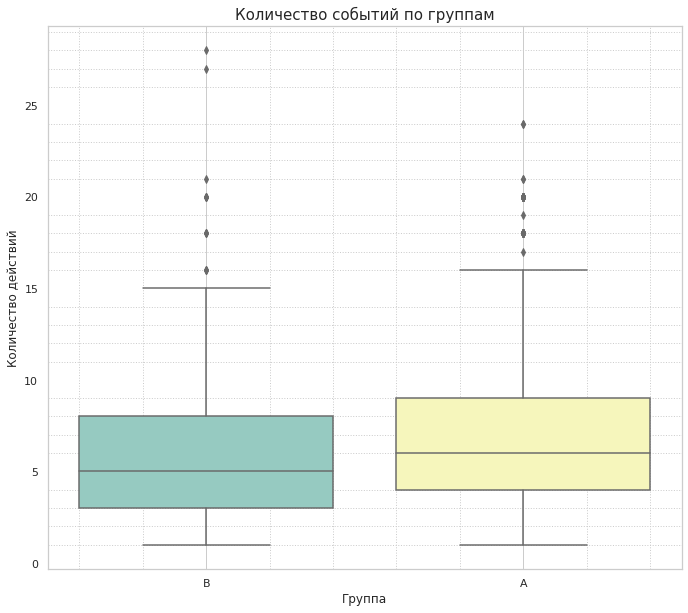

In [891]:
sns.set_theme(style = 'whitegrid')
plt.figure(figsize = (25, 10))
plt.subplot(1,2,1)
sns.boxplot(x = 'group', y = 'event_name', data = dff, palette = 'Set3')
plt.minorticks_on()
plt.grid(which = 'major')
plt.grid(which = 'minor', linestyle = ':')

plt.title('Количество событий по группам', fontsize = 15)
plt.ylabel('Количество действий')
plt.xlabel('Группа')

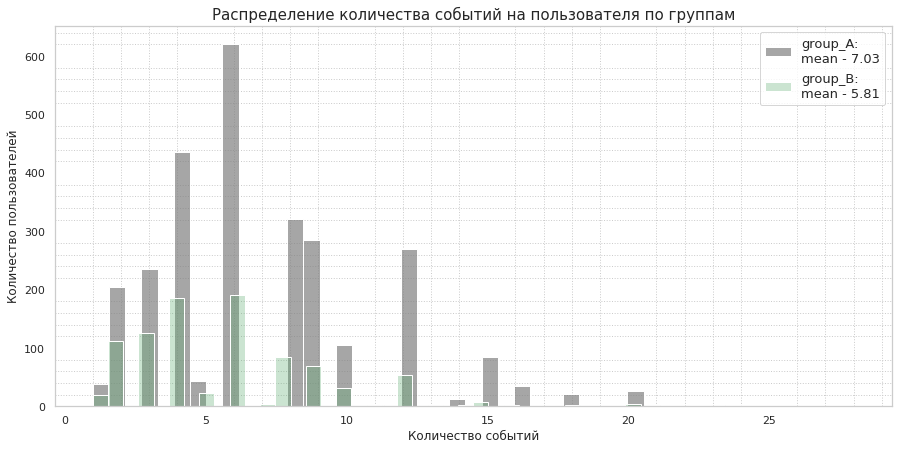

In [892]:
# построим график полученных групп
plt.figure(figsize = (15, 7))

ax = sns.histplot(data = cnt_ev.query("A != 0")['A'], alpha = .7, bins = 40, color = 'grey')
sns.histplot(data = cnt_ev.query("B != 0")['B'], alpha = .3,  ax = ax, color = 'g', bins = 50)

plt.minorticks_on()
plt.grid(which = 'major')
plt.grid(which = 'minor', linestyle = ':')

plt.title('Распределение количества событий на пользователя по группам', fontsize = 15)
plt.xlabel('Количество событий')
plt.ylabel('Количество пользователей')

group_A = 'group_A:\nmean - {:.2f}'.format(cnt_ev.A.mean())
group_B = 'group_B:\nmean - {:.2f}'.format(cnt_ev.B.mean())

plt.legend([group_A, group_B], prop={'size':13})
plt.show()

<b>Вывод:</b>

В целом наблюдается ровное рапределение событий по пользователям, в группе А участники совершают на 1 действие больше чем в группе В. Разница из-за разного количества пользователей в группах, но при этом средние значения близки к равному.

<a name = "2.2."></a><font size = "3"><b>2.2 Распределение событий по дням</b></font><br/>
<font size = "2">[содержание](#0.0)</font>

In [893]:
df.head()

,user_id,group,ab_test,event_dt,event_name,details,first_dt,region,device,date
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,purchase,99.99,2020-12-07,EU,PC,2020-12-07
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:56,purchase,4.99,2020-12-07,EU,PC,2020-12-25
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:29,product_cart,0.00,2020-12-07,EU,PC,2020-12-07
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:57,product_cart,0.00,2020-12-07,EU,PC,2020-12-25
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,product_page,0.00,2020-12-07,EU,PC,2020-12-07


In [894]:
# разделим количество событий по группам и датам
dev = df.pivot_table(index = ['date', 'event_name'], values = 'user_id', columns = 'group', aggfunc = 'count').reset_index()
dev

group,date,event_name,A,B
0,2020-12-07,login,154,165
1,2020-12-07,product_cart,35,46
2,2020-12-07,product_page,96,108
3,2020-12-07,purchase,46,59
4,2020-12-08,login,159,119
...,...,...,...,...
87,2020-12-28,purchase,71,10
88,2020-12-29,login,200,39
89,2020-12-29,product_cart,55,6
90,2020-12-29,product_page,132,20


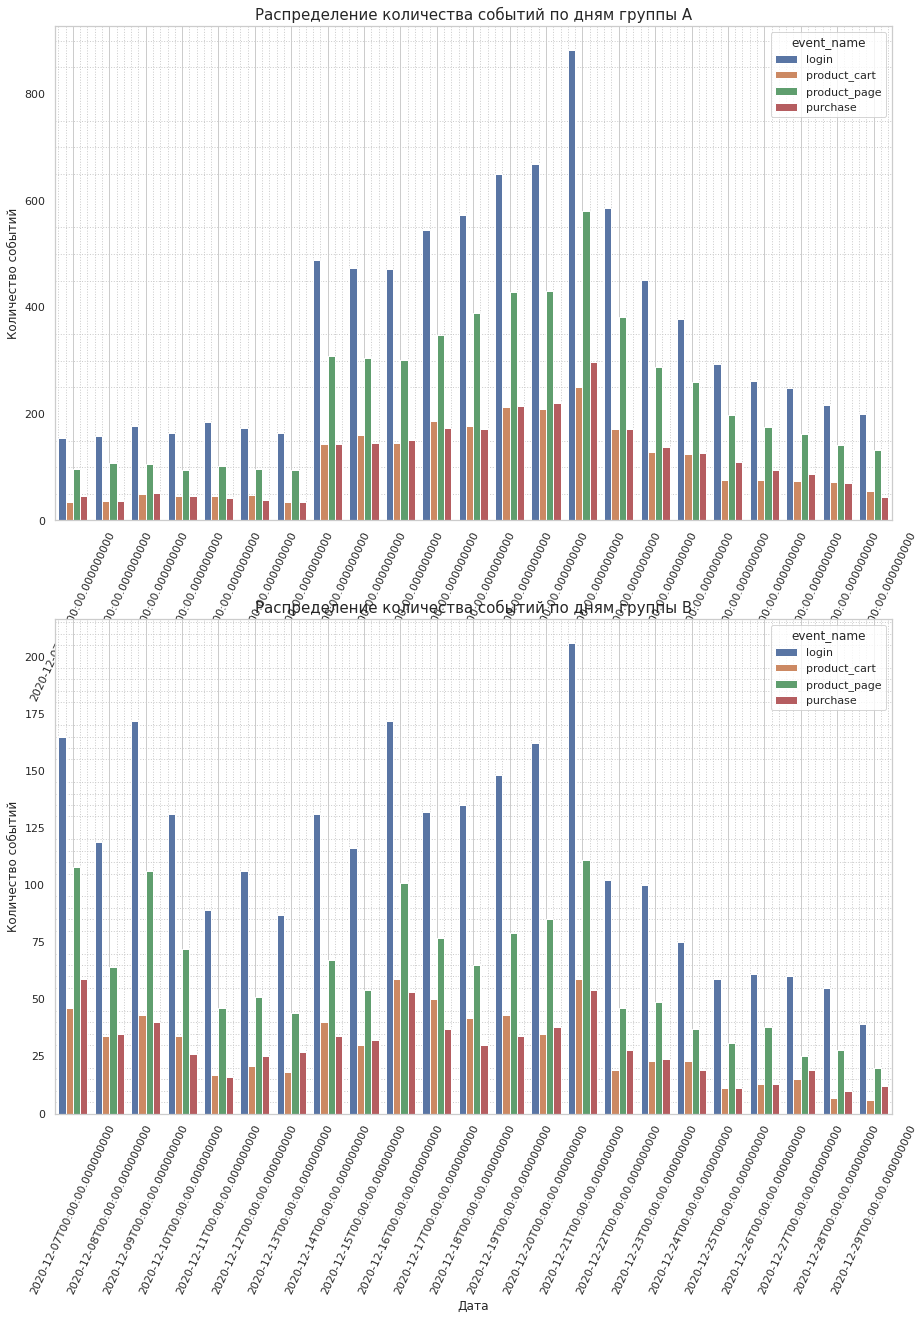

In [895]:
# отобразим события по группам и по датам
# группа А
plt.figure(figsize = (15, 20))

plt.subplot(2,1,1)
sns.barplot(data = dev, x = 'date', y = 'A', hue = 'event_name')

plt.minorticks_on()
plt.grid(which = 'major')
plt.grid(which = 'minor', linestyle = ':')

plt.title('Распределение количества событий по дням группы А', fontsize = 15)
plt.xlabel('Дата')
plt.ylabel('Количество событий')

plt.xticks(rotation = 65)

# группа В
plt.subplot(2,1,2)
sns.barplot(data = dev, x = 'date', y = 'B', hue = 'event_name')

plt.minorticks_on()
plt.grid(which = 'major')
plt.grid(which = 'minor', linestyle = ':')

plt.title('Распределение количества событий по дням группы B', fontsize = 15)
plt.xlabel('Дата')
plt.ylabel('Количество событий')

plt.xticks(rotation = 65)
plt.show()

<b>Вывод:</b>

Если смотреть картину в общем то до 21 числа наблюдается рост событий, а после спад. У группы В до 13 числа включительно наблюдается снижение событий, а после до 21.12.2020 - увеличение. У группы А до 13 числа видно, что события распределялись равномерно, а после пошел рост. После 21 числа идет равномерный спад в обоих группах и мероприятия, начавшиеся с 25.12.2020 не исказили нам основную тенденцию.

<a name = "2.3."></a><font size = "3"><b>2.3 Как меняется конверсия в воронке на разных этапах</b></font><br/>
<font size = "2">[содержание](#0.0)</font>

In [896]:
# Посмотреть, какие события есть в логах, как часто они встречаются
df_ev = df.groupby('event_name').agg({'user_id' : 'count'}).reset_index().sort_values(by = 'user_id', ascending = False)
df_ev.columns = ['event_name', 'count']
df_ev

,event_name,count
0,login,11188
2,product_page,6929
3,purchase,3331
1,product_cart,3246


In [897]:
# покупок больше, чем просмотр продуктовых корзин. добавим сортировку для правильной последовательности этапов
def x(data):
    if data.event_name == 'login':
        data['step'] = 0
    elif data.event_name == 'product_page':
        data['step'] = 1
    elif data.event_name == 'product_cart':
        data['step'] = 2
    elif data.event_name == 'purchase':
        data['step'] = 3
    return data

df_ev = df_ev.apply(x, axis = 1)

In [898]:
# посчитаем сколько пользователей совершали каждое из этих собиытий
df_uni = df.groupby('event_name').agg({'user_id' : 'nunique'}).reset_index().sort_values(by = 'user_id', ascending = False)
df_uni['percent'] = (df_uni['user_id'] / df['user_id'].nunique() * 100).round(1) 
df_uni

,event_name,user_id,percent
0,login,3675,100.0
2,product_page,2303,62.7
3,purchase,1128,30.7
1,product_cart,1079,29.4


In [899]:
df_uni = df_uni.apply(x, axis = 1)
df_uni = df_uni.sort_values(by = 'step')

In [900]:
# построим график
fig = go.Figure()
fig.add_trace(go.Funnel(
    y = df_uni['event_name'],
    x = df_uni['user_id'],
    textinfo = "value+percent initial",
    hoverinfo = "percent initial+percent previous")
    )
fig.update_layout(title = "Колличество событий в логе")
fig.show()

<b>Вывод:</b>

- Отмечено событий:
- вход в профиль 3675
- просмотр страницы с продуктами 2303 (62.7%)
- просмотр корзины 1079 (29.4%)
- покупка 1128 (30.7%)

______________________

- Заметим, что покупок больше, чем просмотр продуктовой корзины на 1.3%. Возможно связано с покупкой в обход корзины.
- Также уникальных пользователей, которые просмотрели страницу с продуктов практически половина (30.7%) из них приобрели товар.

<a name = '3.'></a><font size = '4'><b>3. Оценка результатов A/B-тестирования</b></font><br>
<font size = '2'>[Содержание](#0.0)</font>

<a name = "3.1."></a><font size = "3"><b>3.1 Анализ результатов A/B-тестирования</b></font><br/>
<font size = "2">[содержание](#0.0)</font>

In [901]:
# посмотрим как в группах происходила конверсия по этапам
df_A = df.query("group == 'A'").groupby('event_name').agg({'user_id' : 'nunique'}).reset_index().sort_values(by = 'user_id', ascending = False)
df_A['percent'] = (df_A['user_id'] / df['user_id'].nunique() * 100).round(1)

In [902]:
df_A = df_A.apply(x, axis = 1)
df_A = df_A.sort_values(by = 'step')

In [903]:
# построим график
fig = go.Figure()
fig.add_trace(go.Funnel(
    y = df_A['event_name'],
    x = df_A['user_id'],
    textinfo = "value+percent initial",
    hoverinfo = "percent initial+percent previous")
    )
fig.update_layout(title = "Колличество событий в логе (group A)")
fig.show()

In [904]:
df_B = df.query("group == 'B'").groupby('event_name').agg({'user_id' : 'nunique'}).reset_index().sort_values(by = 'user_id', ascending = False)
df_B['percent'] = (df_B['user_id'] / df['user_id'].nunique() * 100).round(1) 
df_B

,event_name,user_id,percent
0,login,928,25.3
2,product_page,523,14.2
3,purchase,256,7.0
1,product_cart,255,6.9


In [905]:
df_B = df_B.apply(x, axis = 1)
df_B = df_B.sort_values(by = 'step')

In [906]:
# построим график
fig = go.Figure()
fig.add_trace(go.Funnel(
    y = df_B['event_name'],
    x = df_B['user_id'],
    textinfo = "value+percent initial",
    hoverinfo = "percent initial+percent previous")
    )
fig.update_layout(title = "Колличество событий в логе (group B)")
fig.show()

<b>Вывод:</b>

- Группы по события не равны в значительной мере (группа А в 3 раза больше совершает действий, нежели группа В)
- Отметим, что при таком большом разновесе в количестве пользователей, разница в конверсии между групами небольшая:
    - продуктовая страница, разница 8.4%
    - корзина, разница 2.5%
    - покупки, разница 4.1%

<a name = "3.2."></a><font size = "3"><b>3.2 Проверка статистической разницы долей z-критерием</b></font><br/>
<font size = "2">[содержание](#0.0)</font>

In [907]:
gr_ab = df.pivot_table(index = 'event_name', columns = 'group', values = 'user_id', aggfunc = 'nunique').reset_index()
gr_ab['perc_a'] = (gr_ab['A'] / df['user_id'].nunique() * 100).round(1)
gr_ab['perc_b'] = (gr_ab['B'] / df['user_id'].nunique() * 100).round(1) 
gr_ab = gr_ab.apply(x, axis =1).sort_values(by = 'step')
gr_ab

group,event_name,A,B,perc_a,perc_b,step
0,login,2747,928,74.7,25.3,0
2,product_page,1780,523,48.4,14.2,1
1,product_cart,824,255,22.4,6.9,2
3,purchase,872,256,23.7,7.0,3


<b>Гипотезы:</b><br>
Применим **метод** `Бонферони` для снижения вероятности ложнопозитивного результата при множественном тестировании гипотез. <br>
Разделим уровень значимости <b>0.05</b> на число сравнений <b>3</b> <br>
<b>Нулевая:</b> Статистически значимой разницы между долями нет.<br>
<b>Альтернативная:</b> Статистически значимая разница между долями есть.<br>
Критический уровень статистической значимости <b>Alpha</b> = <b>0.05</b>


In [908]:
# создадим функцию, которая будет принимать значения первой и второй групп,
# а выдавать статистическую разницу по ним по каждому событию

def z_test(a1, a2, b1, b2):
    alpha = 0.05 / 3
    
    # исходные данные
    ft = np.array([a1, b1])
    nt = np.array([a2, b2])

    # пропорция успехов в первой группе:
    p1 = nt[0]/ft[0]

    # пропорция успехов во второй группе:
    p2 = nt[1]/ft[1]

    # пропорция успехов в комбинированном датасете:
    p_cd = (nt[0] + nt[1]) / (ft[0] + ft[1])

    # разница пропорций в датасетах
    difference = p1 - p2

    z_value = difference / mt.sqrt(p_cd * (1 - p_cd) * (1/ft[0] + 1/ft[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = stats.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', round(p_value, 2))
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу, есть статистически значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет статистически значимой разницы")

In [909]:
gr_ab

group,event_name,A,B,perc_a,perc_b,step
0,login,2747,928,74.7,25.3,0
2,product_page,1780,523,48.4,14.2,1
1,product_cart,824,255,22.4,6.9,2
3,purchase,872,256,23.7,7.0,3


In [910]:
print('События product_page')
z_test(gr_ab.loc[0, 'A'], gr_ab.loc[2, 'A'], gr_ab.loc[0, 'B'], gr_ab.loc[2, 'B'])
print('____________________________________')
print('События product_cart')
z_test(gr_ab.loc[0, 'A'], gr_ab.loc[1, 'A'], gr_ab.loc[0, 'B'], gr_ab.loc[1, 'B'])
print('____________________________________')
print('События purchase')
z_test(gr_ab.loc[0, 'A'], gr_ab.loc[3, 'A'], gr_ab.loc[0, 'B'], gr_ab.loc[3, 'B'])

События product_page
p-значение:  0.0
Отвергаем нулевую гипотезу, есть статистически значимая разница
____________________________________
События product_cart
p-значение:  0.15
Не получилось отвергнуть нулевую гипотезу, нет статистически значимой разницы
____________________________________
События purchase
p-значение:  0.02
Не получилось отвергнуть нулевую гипотезу, нет статистически значимой разницы


<b>Выввод:</b>

- В сравниваемых группах А и В на шаге <b>product_page (р-значение: 0)</b> наблюдается статистически значимая разница конверсий, это означает, что улучшенная рекомендательная система имеет влияние на поведение пользователей и переходы по воронке только на этом этапе.
- Этапы событий <b>product_cart (p-значение:  0.15) и purchase (р-значение: 0.02)</b> показали обратный результат и утверждать, что влияния новой системы нет затруднительно.

<a name = '4.'></a><font size = '4'><b>4. Вывод</b></font><br>
<font size = '2'>[Содержание](#0.0)</font>

<font size = "3"><b>Задача:</b></font><br>
Провести оценку результатов <b>A/B-теста</b>

______________________


<b>Техническое задание:</b>
- Название теста: `recommender_system_test`;
- группы:
    * А — контрольная,
    * B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.
    
______________________
    
* группа пользователей состоит из 18268 строк
* уникальных пользователей 16666, две группы А и В, а также указано два теста.

Использовали только данные  из теста `recommender_system_test`<br>
Количество пользователей, которые участвовали в двух тестах: 1602

______________________

- Определили, что действия пользователи совершали до 31 декабря
- 30 декабря совершено всего 4: действия два пользователя залогинились и просмотрели карточку
- Оставили для дальнейшего анализа информацию до 30 декабря 2020 года
- c 25 декабря 2020 по 03 января 2021 проходило мероприятие Christmas&New Year Promo и с 30 декабря 2020 по 07 января 2021 CIS New Year Gift Lottery. Влияние на поведение пользователей будет иметь мероприятие только Christmas&New Year Promo.
- всего уникальных пользователей выходит 6701, в тесте участвовали 3675 пользователей
- Распределение тестовых групп имеет различия - группа А имеет 2747 участников (74.7%) и группы В 928 участника (25.3%)
- Новых пользователей из региона EU меньше практически в два раза по сравнению с условиями по техническому заданию - 8.2%.


- Теперь мы знаем, что всего уникальных пользователей <b>16666</b> из них <b>5099</b> участвуют в тесте `recommender_system_test` и <b>9965</b> в тесте `interface_eu_test`. А <b>1602</b> пользователя принимали участие в обоих тестах
- <b>776</b> пользователей принимали участие в двух тестах групп <b>А</b> и <b>В</b>
- Определили, что пользователей которые участвуют в одной из групп относятся к `interface_eu_test`

В целом наблюдается ровное рапределение событий по пользователям. Разница из-за разного количества пользователей в группах, но при этом средние значения близки к равному.

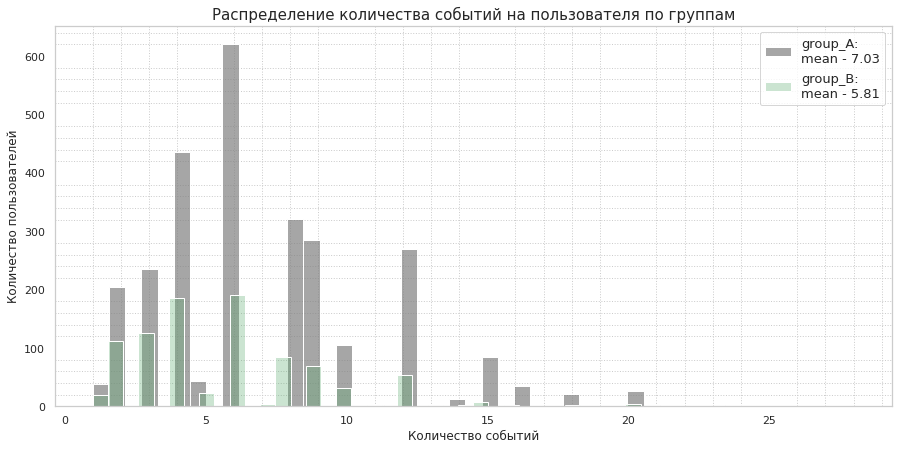

In [911]:
plt.figure(figsize = (15, 7))

ax = sns.histplot(data = cnt_ev.query("A != 0")['A'], alpha = .7, bins = 40, color = 'grey')
sns.histplot(data = cnt_ev.query("B != 0")['B'], alpha = .3,  ax = ax, color = 'g', bins = 50)

plt.minorticks_on()
plt.grid(which = 'major')
plt.grid(which = 'minor', linestyle = ':')

plt.title('Распределение количества событий на пользователя по группам', fontsize = 15)
plt.xlabel('Количество событий')
plt.ylabel('Количество пользователей')

group_A = 'group_A:\nmean - {:.2f}'.format(cnt_ev.A.mean())
group_B = 'group_B:\nmean - {:.2f}'.format(cnt_ev.B.mean())

plt.legend([group_A, group_B], prop={'size':13})
plt.show()

В целом наблюдается ровное рапределение событий по пользователям, в группе А участники совершают на 1 действие больше чем в группе В. Разница из-за разного количества пользователей в группах, но при этом средние значения близки к равному.

Если смотреть картину в общем то до 21 числа наблюдается рост событий, а после спад. У группы В до 13 числа включительно наблюдается снижение событий, а после до 21.12.2020 - увеличение. У группы А до 13 числа видно, что события распределялись равномерно, а после пошел рост. После 21 числа идет равномерный спад в обоих группах и мероприятия, начавшиеся с 25.12.2020 не исказили нам основную тенденцию.

______________________

- Отмечено событий:
- вход в профиль 3675
- просмотр страницы с продуктами 2303 (62.7%)
- просмотр корзины 1079 (29.4%)
- покупка 1128 (30.7%)

______________________

- Заметим, что покупок больше, чем просмотр продуктовой корзины на 1.3%. Возможно связано с покупкой в обход корзины.
- Также уникальных пользователей, которые просмотрели страницу с продуктов практически половина (30.7%) из них приобрели товар.


<b>______________________</b>

Проверка статистической разницы долей <b>z-критерием</b><br>
<b>Гипотезы:</b><br>
Применили **метод** `Бонферони` для снижения вероятности ложнопозитивного результата при множественном тестировании гипотез. <br>
Разделили уровень значимости <b>0.05</b> на число сравнений <b>3</b> <br>
<b>Нулевая:</b> Статистически значимой разницы между долями нет.<br>
<b>Альтернативная:</b> Статистически значимая разница между долями есть.<br>
Критический уровень статистической значимости <b>Alpha</b> = <b>0.05</b>

<b>Результат:</b>
- В сравниваемых группах А и В на шаге <b>product_page (р-значение: 0)</b> наблюдается статистически значимая разница конверсий, это означает, что улучшенная рекомендательная система имеет влияние на поведение пользователей и переходы по воронке только на этом этапе.
- Этапы событий <b>product_cart (p-значение:  0.15) и purchase (р-значение: 0.02)</b> показали обратный результат и утверждать, что влияния новой системы нет затруднительно.


Подводя итог, отметим несоответствие фактического анализа условиям для проведения теста, но при этом, проверка статистической значимости показала влияние ркомендательной системы. Но учитывая все моменты говорить точно, что повлияло нарезультат и давать точные оценки не можем.


<b>Рекомендация:</b> Так как много условий были не соблюдены, стоит провести тест повторно, но уже учесть моменты выше обозначенные.